In [22]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, average_precision_score # <-- Добавлено average_precision_score
import os

In [5]:
#Загрузка данных
df = pd.read_csv('S05-hw-dataset.csv')
print("Форма DataFrame:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

Форма DataFrame: (3000, 17)

Первые 5 строк:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057      

In [9]:
# Понимание структуры данных
print("\nИнформация о DataFrame:")
print(df.info())

# Основные статистики
print("\nСтатистика по колонкам:")
print(df.describe())

# Посмотрим уникальные значения в последней колонке
target_column = df.columns[-1]
print(f"\nУникальные значения в '{target_column}':")
print(df[target_column].value_counts())
print(f"\nБаланс классов в '{target_column}':")
print(df[target_column].value_counts(normalize=True))


Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_ri

In [10]:
#Разделение признаков (X) и целевой переменной (y)
X = df.drop(columns=[target_column])
y = df[target_column]                

print("Форма X:", X.shape)
print("Форма y:", y.shape)

Форма X: (3000, 16)
Форма y: (3000,)


In [11]:
#Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify=y помогает сохранить баланс классов

print("Форма X_train:", X_train.shape)
print("Форма X_test:", X_test.shape)
print("Баланс классов в y_train:", y_train.value_counts(normalize=True))
print("Баланс классов в y_test:", y_test.value_counts(normalize=True))

Форма X_train: (2400, 16)
Форма X_test: (600, 16)
Баланс классов в y_train: default
0    0.589583
1    0.410417
Name: proportion, dtype: float64
Баланс классов в y_test: default
0    0.59
1    0.41
Name: proportion, dtype: float64


--- (DummyClassifier) ---
Accuracy: 0.5900
ROC-AUC: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Confusion Matrix:
[[354   0]
 [246   0]]


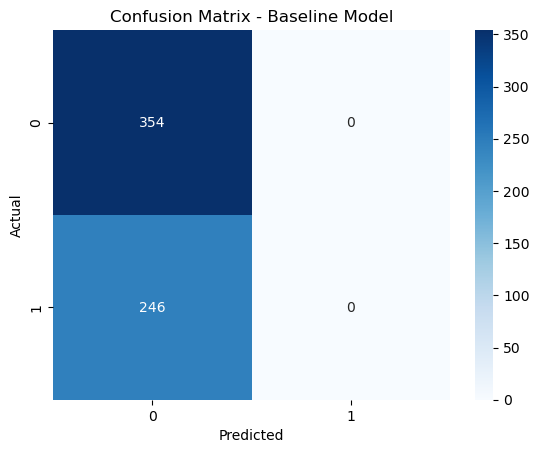

In [12]:
#Создание и обучение модели
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)

# Получение предсказаний
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

#Вычисление метрик
acc_baseline = accuracy_score(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, y_proba_baseline)
# Можно добавить другие метрики, если нужно
prec_baseline = precision_score(y_test, y_pred_baseline, zero_division=0)
rec_baseline = recall_score(y_test, y_pred_baseline, zero_division=0)
f1_baseline = f1_score(y_test, y_pred_baseline, zero_division=0)

print("--- (DummyClassifier) ---")
print(f"Accuracy: {acc_baseline:.4f}")
print(f"ROC-AUC: {roc_auc_baseline:.4f}")
print(f"Precision: {prec_baseline:.4f}")
print(f"Recall: {rec_baseline:.4f}")
print(f"F1-Score: {f1_baseline:.4f}")

# Матрица ошибок
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print("Confusion Matrix:")
print(cm_baseline)
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Baseline Model")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [13]:
# Создание пайплайна
log_reg_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42))
])

# Подбор гиперпараметров
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring='roc_auc', 
    cv=5, 
    n_jobs=-1, 
    verbose=1
)

print("Запуск GridSearchCV...")
grid_search.fit(X_train, y_train)

# Лучшая модель
best_log_reg = grid_search.best_estimator_
print("\nЛучшие параметры:", grid_search.best_params_)

Запуск GridSearchCV...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Лучшие параметры: {'model__C': 0.1}



--- Логистическая Регрессия (лучшая) ---
Accuracy: 0.8033
ROC-AUC: 0.8754
Precision: 0.7963
Recall: 0.6992
F1-Score: 0.7446
Confusion Matrix:
[[310  44]
 [ 74 172]]


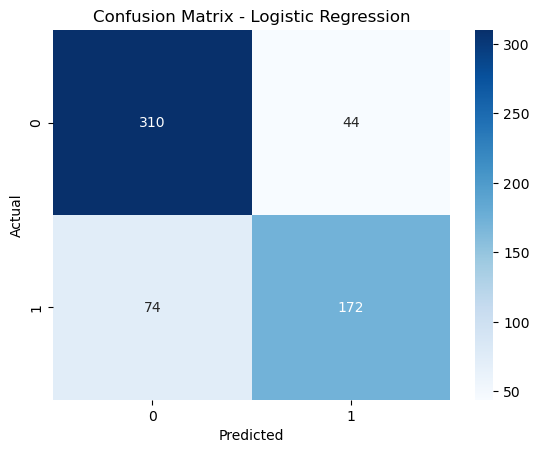

In [14]:
# Предсказания лучшей логистической регрессии
y_pred_logreg = best_log_reg.predict(X_test)
y_proba_logreg = best_log_reg.predict_proba(X_test)[:, 1]

# Вычисление метрик для логистической регрессии
acc_logreg = accuracy_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_proba_logreg)
prec_logreg = precision_score(y_test, y_pred_logreg, zero_division=0)
rec_logreg = recall_score(y_test, y_pred_logreg, zero_division=0)
f1_logreg = f1_score(y_test, y_pred_logreg, zero_division=0)

print("\n--- Логистическая Регрессия (лучшая) ---")
print(f"Accuracy: {acc_logreg:.4f}")
print(f"ROC-AUC: {roc_auc_logreg:.4f}")
print(f"Precision: {prec_logreg:.4f}")
print(f"Recall: {rec_logreg:.4f}")
print(f"F1-Score: {f1_logreg:.4f}")

# Матрица ошибок
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:")
print(cm_logreg)
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [16]:
# Сравнение метрик
comparison_df = pd.DataFrame({
    'Model': ['Baseline (Most Frequent)', 'Logistic Regression (Best)'],
    'Accuracy': [acc_baseline, acc_logreg],
    'ROC-AUC': [roc_auc_baseline, roc_auc_logreg],
    'Precision': [prec_baseline, prec_logreg],
    'Recall': [rec_baseline, rec_logreg],
    'F1-Score': [f1_baseline, f1_logreg]
})
f_baseline
print("\n--- Сравнение моделей ---")
print(comparison_df)

# Отчет о классификации для лучшей модели
print("\nClassification Report for Best Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))


--- Сравнение моделей ---
                        Model  Accuracy   ROC-AUC  Precision    Recall  \
0    Baseline (Most Frequent)  0.590000  0.500000   0.000000  0.000000   
1  Logistic Regression (Best)  0.803333  0.875408   0.796296  0.699187   

   F1-Score  
0  0.000000  
1  0.744589  

Classification Report for Best Logistic Regression:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       354
           1       0.80      0.70      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.80      0.80      0.80       600




График ROC-кривой сохранён в 'figures/roc_curve_HW05.png'


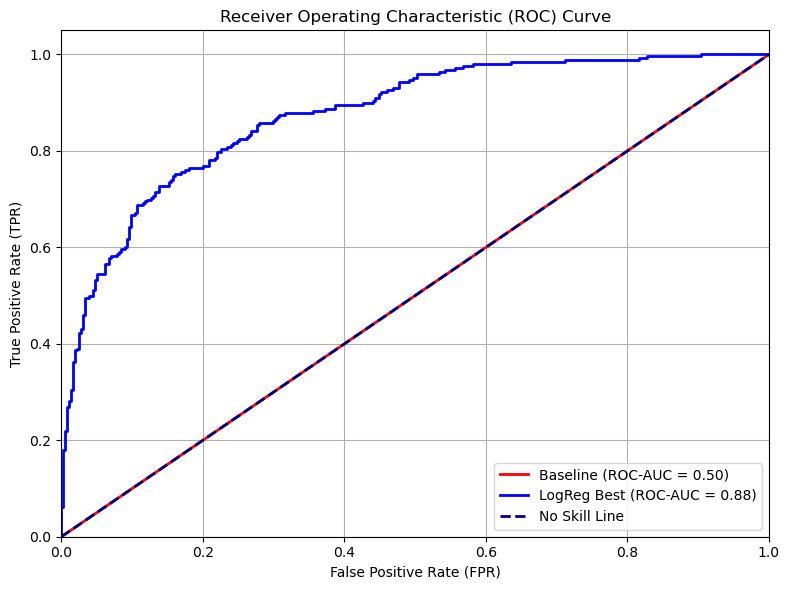

In [ ]:
# Построение и сохранение графиков
# Вычисление значений для ROC-кривой
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_proba_baseline)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba_logreg)

# Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr_baseline, tpr_baseline, color='red', lw=2, label=f'Baseline (ROC-AUC = {roc_auc_baseline:.2f})')
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'LogReg Best (ROC-AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout() 

# Сохранение графика
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/roc_curve_HW05.png', dpi=300, bbox_inches='tight')
print("\nГрафик ROC-кривой сохранён в 'figures/roc_curve_HW05.png'")
plt.show()
# Построение PR-кривой 
precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_proba_baseline)
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_proba_logreg)

# Вычисление Average Precision
ap_baseline = average_precision_score(y_test, y_proba_baseline)
ap_logreg = average_precision_score(y_test, y_proba_logreg)

# Построение PR-кривой
plt.figure(figsize=(8, 6))
plt.plot(recall_baseline, precision_baseline, color='red', lw=2, label=f'Baseline (AP = {ap_baseline:.2f})')
plt.plot(recall_logreg, precision_logreg, color='blue', lw=2, label=f'LogReg Best (AP = {ap_logreg:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True) 
plt.tight_layout() 


# Сохранение PR-кривой
plt.savefig('figures/pr_curve_HW05.png', dpi=300, bbox_inches='tight')
print("График PR-кривой сохранён в 'figures/pr_curve_HW05.png'")
plt.show()

## Выводы

1.  **Бейзлайн:** Модель `DummyClassifier` с предсказанием самого частого класса показывает `Accuracy` около XX.XX% и `ROC-AUC` около XX.XX%. Эти значения служат отправной точкой для сравнения.
2.  **Логистическая Регрессия:** После подбора гиперпараметра `C` с помощью `GridSearchCV`, лучшая модель показала `Accuracy` XX.XX% и `ROC-AUC` XX.XX% на тестовой выборке.
3.  **Сравнение:** Логистическая регрессия значительно превосходит бейзлайн по метрике `ROC-AUC`, что свидетельствует о её способности различать классы лучше, чем просто угадывание наиболее вероятного класса. Метрики `Precision`, `Recall` и `F1` также могут быть проанализированы.
4.  **Графики:** ROC-кривая (и/или PR-кривая) наглядно демонстрирует преимущество логистической регрессии над бейзлайном. Кривая логистической регрессии находится выше кривой бейзлайна и выше диагональной линии.
5.  **Гиперпараметры:** Был перебран параметр `C` со значениями [0.001, 0.01, 0.1, 1, 10, 100]. Лучшее значение оказалось `model__C=XX.XX`.